In [30]:
from desc.compute.utils import get_transforms, get_profiles, get_params
from desc.compute import compute as compute_fun
from desc.backend import jnp
from desc.grid import Grid
import desc.io
import desc.examples
from functools import partial
from jax import jit
from jax.experimental.ode import odeint as jax_odeint
import matplotlib.pyplot as plt
import numpy as np

eq = desc.io.load("test_run.h5")
eq._iota = eq.get_profile("iota")
eq._current = None 

"""
#plot_3d(eq, "|B|")
# a = [energy, const1, const2, const3, B_ref]
#normalizar o tempo: t_tilde = t*omega
#normalizar o psi: psi_tilde = b_ref*(L^2) L tamanho a definir (Raio de Larmor) 
#normalizar a velocidade - v_tilde = v/(L*omega) //// v_tidle = v/sqrt(2E/m)
#omega = q*B_ref/m
B_tilde = data["B"]/B_ref
B_abs_tilde = data["|B|"]/B_ref
grad_B_tilde = data["grad(|B|)"]/B_ref 
"""

def rhs(w, t, a):
    #initial conditions
    psi, theta, zeta, vpar = w
    
    keys = ["B", "|B|", "grad(|B|)", "grad(psi)", "e^theta", "e^zeta", "G"] # etc etc, whatever terms you need
    grid = Grid(jnp.array([psi, theta, zeta]).T, jitable=True, sort=False)
    transforms = get_transforms(keys, eq, grid, jitable=True)
    profiles = get_profiles(keys, eq, grid, jitable=True)
    params = get_params(keys, eq)
    data = compute_fun(eq, keys, params, transforms, profiles)
    
    E, m_q = a
    m = m_q*1.6e-19

    b = (data["B"]/data["|B|"]) 
    mu = E/(m*data["|B|"]) - (vpar**2)/(2*data["|B|"])
    


    psidot = m_q*(1/data["|B|"]**3)*(mu*data["|B|"] + vpar**2) * jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis = -1) * data["grad(psi)"])    
    thetadot = (vpar/data["|B|"]) * jnp.sum(data["B"] * data["e^theta"]) + m_q*(1/data["|B|"]**3)*(mu*data["|B|"] + vpar**2)*jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis=-1) * data["e^theta"])
    zetadot = (vpar/data["|B|"]) * jnp.sum(data["B"]* data["e^zeta"]) 
    vpardot = -mu*jnp.sum(b* data["grad(|B|)"])    
    
    return jnp.array([psidot, thetadot, zetadot, vpardot])

In [31]:
def run(E_, q_, m_, t_i, t_f, nt_ ,psi_i, theta_i, zeta_i, vpar_i_ratio):
    e_charge = q_*1.6e-19
    m = m_*1.673e-27
    tmin = t_i
    tmax = t_f
    nt = nt_
    E = E_*3.52e6*e_charge
    m_q = m/e_charge

    v_parallel = vpar_i_ratio*jnp.sqrt(2*E/m)
    a_initial = [E, m_q]
    initial_conditions = [psi_i, theta_i, zeta_i, v_parallel]

    def solve_with_jax(a=None):
        initial_conditions_jax = jnp.array(initial_conditions, dtype=jnp.float64)
        a_jax = jnp.array(a_initial, dtype=jnp.float64)
        t_jax = jnp.linspace(tmin, tmax, nt)
        system_jit = jit(rhs)
        solution_jax = jax_odeint(partial(system_jit, a=a_jax), initial_conditions_jax, t_jax)
        return solution_jax
    
    sol = solve_with_jax()
    print(sol)

    return sol


In [35]:
E_ = 1
q_= 2
m_ = 4
t_i = 0 
t_f = 1e-5
nt_ = 140
psi_i = 0.25
theta_i = 0.25
zeta_i = 0
vpar_i_ratio = 0.2
sol = run(1, 2, 4, 0, 3e-5, 140, 0.25, 0.25, 0, 0.70)

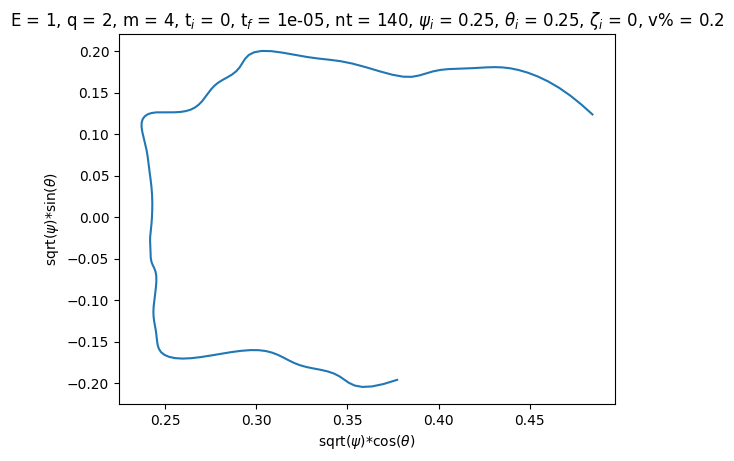

In [34]:
plt.plot(np.sqrt(sol[:, 0]) * np.cos(sol[:, 1]), np.sqrt(sol[:, 0]) * np.sin(sol[:, 1]))
plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.title(rf'E = {E_}, q = {q_}, m = {m_}, t$_i$ = {t_i}, t$_f$ = {t_f}, nt = {nt_}, $\psi_i$ = {psi_i}, $\theta_i$ = {theta_i}, $\zeta_i$ = {zeta_i}, v% = {vpar_i_ratio}')
plt.show()